# Параллельные вычисления

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Параллельные вычисления"
* https://docs.python.org/3/library/multiprocessing.html
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Process
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Queue
* https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
* https://numpy.org/doc/stable/reference/generated/numpy.array_split.html
* https://nalepae.github.io/pandarallel/
    * https://github.com/nalepae/pandarallel/blob/master/docs/examples_windows.ipynb
    * https://github.com/nalepae/pandarallel/blob/master/docs/examples_mac_linux.ipynb

## Задачи для совместного разбора

In [1]:
# !pip install pandarallel

1. Посчитайте, сколько раз встречается буква "a" в файлах ["xaa", "xab", "xac", "xad"]. 

In [2]:
import multiprocessing

files = [f"{name}.txt" for name in ["xaa", "xab", "xac", "xad"]]

In [3]:
from collections import Counter

def count_a(file):
    with open(file) as fp:
        text = fp.read().lower()
    res = Counter(text)["a"]
    print(file, res)
    return res

In [4]:
%%time
[count_a(f) for f in files]

xaa.txt 2599627
xab.txt 2605911
xac.txt 2599868
xad.txt 1460452
Wall time: 5.49 s


[2599627, 2605911, 2599868, 1460452]

In [5]:
%%file count_a.py
from collections import Counter

def count_a(file):
    with open(file) as fp:
        text = fp.read().lower()
    res = Counter(text)["a"]
    print(file, res)
    return res

Overwriting count_a.py


In [6]:
from count_a import count_a

In [7]:
%%time
with multiprocessing.Pool(processes=4) as pool:
    res = pool.map(count_a, files)
res

Wall time: 1.85 s


[2599627, 2605911, 2599868, 1460452]

In [8]:
%%file count_a_q.py
from collections import Counter

def count_a_q(file, queue):
    with open(file) as fp:
        text = fp.read().lower()
    res = Counter(text)["a"]
    print(file, res)
    queue.put(res)

Overwriting count_a_q.py


In [9]:
from count_a_q import count_a_q

In [10]:
%%time
ps = []
queue = multiprocessing.Queue()

for f in files:
    p = multiprocessing.Process(target=count_a_q, args=(f, queue))
    ps.append(p)
    p.start()

rs = []
while len(rs) < 4:
    if not queue.empty():
        rs.append(queue.get())
    
for p in ps:
    p.join()

rs

Wall time: 1.69 s


[1460452, 2599627, 2599868, 2605911]

2. Выведите на экран слова из файла words_alpha, в которых есть две или более буквы "e" подряд.

In [11]:
import pandas as pd

words = (
    pd.read_csv("words_alpha.txt", header=None)[0]
    .dropna()
    .sample(frac=1, replace=True)
)

In [12]:
words.size

370103

In [13]:
import re

def f(s): 
    return bool(re.findall(r"e{2,}", s))

In [14]:
%%file f.py
import re

def f(s): 
    return bool(re.findall(r"e{2,}", s))

Overwriting f.py


In [15]:
from f import f

from pandarallel import pandarallel 
pandarallel.initialize()

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [16]:
%%time
words[words.map(f)].size

Wall time: 386 ms


7240

In [17]:
%%time
words[words.parallel_map(f)].size

Wall time: 1.35 s


7240

## Лабораторная работа 10

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy` и `pandas`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy` или структур `pandas` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

**1\.** В каждой строке файла `tag_nsteps.csv` хранится информация о тэге рецепта и количестве шагов в этом рецепте в следующем виде:

```
tags,n_steps
hungarian,2
european,6
occasion,4
pumpkin,4
................
```

Всего в исходном файле хранится чуть меньше, чем 71 млн, строк. Разбейте файл `tag_nsteps.csv` на несколько (например, 8) примерно одинаковых по объему файлов c названиями `tag_nsteps_*.csv`, где вместо символа `*` указан номер очередного файла. Каждый файл имеет структуру, аналогичную оригинальному файлу (включая заголовок).

__Важно__: здесь и далее вы не можете загружать в память весь исходный файл сразу. 

In [1]:
import pandas as pd
import numpy as np

import multiprocessing

In [2]:
%%time
for index, chunk in enumerate(pd.read_csv("tag_nsteps.csv",
                                          chunksize=len(np.array_split(np.arange(0, 70700000, 1), 12)[0]))):
    chunk.to_csv(f'tag_nsteps_{index}.csv', index=None)

**2\.** Напишите функцию, которая принимает на вход название файла, созданного в результате решения задачи 1, считает для каждого тэга сумму по столбцу `n_steps` и количество строк c этим тэгом, и возвращает результат в виде словаря. Ожидаемый вид итогового словаря:

```
{
    '1-day-or-more': {'sum': 56616, 'count': 12752},
    '15-minutes-or-less': {'sum': 195413, 'count': 38898},
    '3-steps-or-less': {'sum': 187938, 'count': 39711},
    ....
}
```

Примените данную функцию к каждому файлу, полученному в задании 1, и соберите результат в виде списка словарей. Не используйте параллельных вычислений. 

Выведите на экран значение по ключу "30-minutes-or-less" для каждого из словарей.

```
tag_nsteps_0.csv		tag_nsteps_1.csv		tag_nsteps_2.csv		tag_nsteps_3.csv
tag_nsteps_4.csv		tag_nsteps_5.csv		tag_nsteps_6.csv		tag_nsteps_7.csv
tag_nsteps_8.csv		tag_nsteps_9.csv		tag_nsteps_10.csv		tag_nsteps_11.csv
```

In [3]:
def get_tag_sum_count_from_file(file: str) -> dict:
    df = pd.read_csv(file)
    return df.groupby('tags')['n_steps'].agg(['sum','count']).to_dict(orient='index')

In [4]:
%%time
files = ["tag_nsteps_0.csv", "tag_nsteps_1.csv", "tag_nsteps_2.csv", "tag_nsteps_3.csv", "tag_nsteps_4.csv", "tag_nsteps_5.csv", "tag_nsteps_6.csv", "tag_nsteps_7.csv", "tag_nsteps_8.csv", "tag_nsteps_9.csv", "tag_nsteps_10.csv", "tag_nsteps_11.csv"]
tag_info_dict = np.vectorize(get_tag_sum_count_from_file)(files)

Wall time: 19.4 s


In [5]:
%%time
get_info_N = lambda d: d["30-minutes-or-less"]
np.vectorize(get_info_N)(tag_info_dict)

Wall time: 0 ns


array([{'sum': 233005, 'count': 30468}, {'sum': 229875, 'count': 30168},
       {'sum': 233038, 'count': 30617}, {'sum': 236441, 'count': 30912},
       {'sum': 229675, 'count': 30241}, {'sum': 232589, 'count': 30412},
       {'sum': 228707, 'count': 30102}, {'sum': 232746, 'count': 30587},
       {'sum': 232491, 'count': 30617}, {'sum': 231020, 'count': 30476},
       {'sum': 231042, 'count': 30518}, {'sum': 232576, 'count': 30664}],
      dtype=object)

**3\.** Напишите функцию, которая объединяет результаты обработки отдельных файлов. Данная функция принимает на вход список словарей, каждый из которых является результатом вызова функции `get_tag_sum_count_from_file` для конкретного файла, и агрегирует эти словари. Не используйте параллельных вычислений.

Процедура агрегации словарей имеет следующий вид:
$$d_{agg}[k] = \{sum: \sum_{i=1}^{n}d_{i}[k][sum], count: \sum_{i=1}^{n}d_{i}[k][count]\}$$
где $d_1, d_2, ..., d_n$- результат вызова функции `get_tag_sum_count_from_file` для конкретных файлов.

Примените данную функцию к результату выполнения задания 2. Выведите на экран результат для тэга "30-minutes-or-less".

In [6]:
def agg_results(tag_sum_count_list: list) -> dict:
    return pd.concat(list(map(lambda x: pd.DataFrame(x).T,
                    tag_sum_count_list))).reset_index().groupby('index')[['sum','count']].sum().to_dict(orient='index')

In [7]:
%%time 
agg_results(tag_info_dict)["30-minutes-or-less"]

Wall time: 151 ms


{'sum': 2783205, 'count': 365782}

**4\.** Напишите функцию, которая считает среднее значение количества шагов для каждого тэга в словаре, имеющего вид, аналогичный словарям в задаче 2, и возвращает результат в виде словаря . Используйте решения задач 1-3, чтобы получить среднее значение количества шагов каждого тэга для всего датасета, имея результаты обработки частей датасета и результат их агрегации. Выведите на экран результат для тэга "30-minutes-or-less".

Определите, за какое время задача решается для всего датасета. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления среднего. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [8]:
def get_tag_sum_count_from_file(file: str) -> dict:
    df = pd.read_csv(file)
    return df.groupby('tags')['n_steps'].agg(['sum','count']).to_dict(orient='index')

In [9]:
def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    df = pd.DataFrame.from_dict(tag_sum_count).T
    df['mean'] = np.round(df['sum']/df['count'],1)
    return df[['mean']].to_dict(orient='index')

In [10]:
def agg_results(tag_mean_list: list) -> dict:
    return pd.concat(list(map(lambda x: pd.DataFrame(x).T,
                              tag_mean_list))).reset_index().groupby('index').mean().round(1).to_dict(orient='index')

In [11]:
%%time
files = ["tag_nsteps_0.csv", "tag_nsteps_1.csv", "tag_nsteps_2.csv", "tag_nsteps_3.csv", "tag_nsteps_4.csv", "tag_nsteps_5.csv", "tag_nsteps_6.csv", "tag_nsteps_7.csv", "tag_nsteps_8.csv", "tag_nsteps_9.csv", "tag_nsteps_10.csv", "tag_nsteps_11.csv"]
tag_info_dict = np.vectorize(get_tag_sum_count_from_file)(files) # вычисляем статистику для каждого ранее разедленного файла
tag_mean_info_dict = np.vectorize(get_tag_mean_n_steps)(tag_info_dict) # вычисляем среднее для каждого полученного словаря
agg_tag_mean_info_dict = agg_results(tag_mean_info_dict) # агрегация словарей с средним значением 
agg_tag_mean_info_dict['30-minutes-or-less']

Wall time: 20 s


{'mean': 7.6}

**5\.** Повторите решение задачи 4, распараллелив вызовы функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Pool`. Для обработки каждого файла создайте свой собственный процесс. Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [12]:
%%file get_tag.py
import pandas as pd
def get_tag_sum_count_from_file(file: str) -> dict:
    df = pd.read_csv(file)
    return df.groupby('tags')['n_steps'].agg(['sum','count']).to_dict(orient='index')

Overwriting get_tag.py


In [13]:
from get_tag import get_tag_sum_count_from_file

In [14]:
%%time
files = ["tag_nsteps_0.csv", "tag_nsteps_1.csv", "tag_nsteps_2.csv", "tag_nsteps_3.csv", "tag_nsteps_4.csv", "tag_nsteps_5.csv", "tag_nsteps_6.csv", "tag_nsteps_7.csv", "tag_nsteps_8.csv", "tag_nsteps_9.csv", "tag_nsteps_10.csv", "tag_nsteps_11.csv"]

with multiprocessing.Pool(processes=len(files)) as pool:
    tag_info_dict = pool.map(get_tag_sum_count_from_file, files)

tag_mean_info_dict = np.vectorize(get_tag_mean_n_steps)(tag_info_dict)
agg_tag_mean_info_dict = agg_results(tag_mean_info_dict)
agg_tag_mean_info_dict["30-minutes-or-less"]

Wall time: 4.65 s


{'mean': 7.6}

**6\.** Повторите решение задачи 4, распараллелив вычисления функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Process`. Для обработки каждого файла создайте свой собственный процесс. Для обмена данными между процессами используйте `multiprocessing.Queue`.

Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [15]:
%%file get_tag.py
import pandas as pd
def get_tag_sum_count_from_file(file: str, queue) -> dict:
    df = pd.read_csv(file)
    queue.put(df.groupby('tags')['n_steps'].agg(['sum','count']).to_dict(orient='index'))

Overwriting get_tag.py


In [16]:
from get_tag import get_tag_sum_count_from_file

In [17]:
%%time
files = ["tag_nsteps_0.csv", "tag_nsteps_1.csv", "tag_nsteps_2.csv", "tag_nsteps_3.csv", "tag_nsteps_4.csv", "tag_nsteps_5.csv", "tag_nsteps_6.csv", "tag_nsteps_7.csv", "tag_nsteps_8.csv", "tag_nsteps_9.csv", "tag_nsteps_10.csv", "tag_nsteps_11.csv"]
    
processes = []
queue = multiprocessing.Queue()

for file in files:
    process = multiprocessing.Process(target=get_tag_sum_count_from_file, args=(file, queue))
    processes.append(process)
    process.start()

tag_info_dict = list()
while len(tag_info_dict) < len(files):
    if not queue.empty():
        tag_info_dict.append(queue.get())
    
for process in processes:
    process.join()

tag_mean_info_dict = np.vectorize(get_tag_mean_n_steps)(tag_info_dict)
agg_tag_mean_info_dict = agg_results(tag_mean_info_dict)
agg_tag_mean_info_dict["30-minutes-or-less"]

Wall time: 4.86 s


{'mean': 7.6}

**7\.** Исследуйте, как влияет количество запущенных одновременно процессов на скорость решения задачи. Узнайте количество ядер вашего процессора $K$. Повторите решение задачи 1, разбив исходный файл на $\frac{K}{2}$, $K$ и $2K$ фрагментов. Для каждого из разбиений повторите решение задачи 5. Визуализируйте зависимость времени выполнения кода от количества файлов в разбиении. Сделайте вывод в виде текстового комментария.

 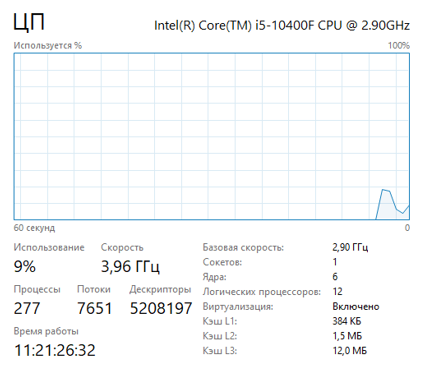

In [18]:
import time
import matplotlib.pyplot as plt

In [19]:
def slicing(K):
    for index, chunk in enumerate(pd.read_csv("tag_nsteps.csv",
                                              chunksize=len(np.array_split(np.arange(0, 70700000, 1), K)[0]))):
        chunk.to_csv(f'tag_nsteps_{K}_{index}.csv',index=None)

In [20]:
%%file get_tag.py
import pandas as pd
def get_tag_sum_count_from_file(file: str) -> dict:
    df = pd.read_csv(file)
    return df.groupby('tags')['n_steps'].agg(['sum','count']).to_dict(orient='index')

Overwriting get_tag.py


In [21]:
from get_tag import get_tag_sum_count_from_file

In [22]:
K = 6
slice_list = [int(K/2), K, 2*K]
time_list = list()

for K in slice_list:
    slicing(K)
    start_time = time.time()
    files = [f"tag_nsteps_{K}_{i}.csv" for i in np.arange(0,K)]

    with multiprocessing.Pool(processes=len(files)) as pool:
        tag_info_dict = pool.map(get_tag_sum_count_from_file, files)

    tag_mean_info_dict = np.vectorize(get_tag_mean_n_steps)(tag_info_dict)
    agg_tag_mean_info_dict = agg_results(tag_mean_info_dict)
    agg_tag_mean_info_dict["30-minutes-or-less"]
    time_list.append(time.time() - start_time)

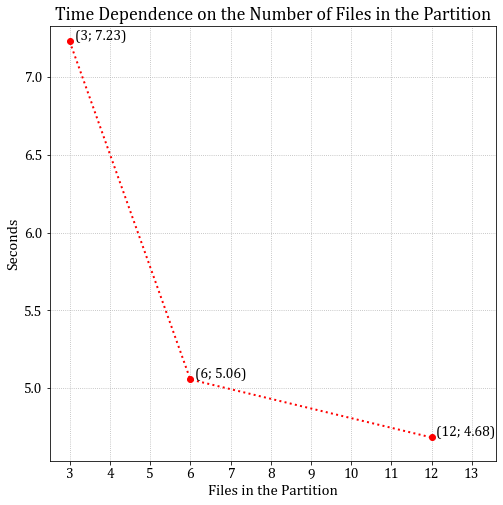

In [23]:
font = {'family': 'serif', 'serif': 'Cambria', 'weight': 'normal','size':14}
plt.rc('font',**font)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(slice_list, time_list, 'red', marker='o', lw=2, linestyle=':')
ax.grid(linestyle=':')

ax.set_ylim(min(time_list)-0.15, max(time_list)+0.1)
ax.set_xlim(min(slice_list)-0.5, max(slice_list)+1.6)

ax.set_xticks(np.arange(min(slice_list), max(slice_list)+2, 1.0))

ax.set_title('Time Dependence on the Number of Files in the Partition', fontsize = 18)
ax.set_xlabel('Files in the Partition', fontsize = 15)
ax.set_ylabel('Seconds', fontsize = 15)

for i in range(len(time_list)):
    ax.annotate(f'({int(slice_list[i])}; {np.round(time_list[i],2)})',
                xy = (slice_list[i]+0.12, time_list[i]+0.01), fontsize = 14)

plt.show()

На графике мы видим, что наилучший показатель времени $(\text{~4.7 секунды})$ оказался в случае, когда мы разбивали файл на $12$ фрагментов. В случае разбиения файла на $6$ фрагментов было затрачено больше всего времени $(\text{~5 секунды})$, а при разбиении на $3$ – чуть меньше $(\text{~7.2 секунды})$. Можем считать, что разбиение файлов на большее число фрагментов дало нам преимущество во времени

**8\.** Напишите функцию `parallel_map`, которая принимает на вход серию `s` `pd.Series` и функцию одного аргумента `f` и поэлементно применяет эту функцию к серии, распараллелив вычисления при помощи пакета `multiprocessing`. Логика работы функции `parallel_map` должна включать следующие действия:
* разбиение исходной серии на $K$ частей, где $K$ - количество ядер вашего процессора;
* параллельное применение функции `f` к каждой части при помощи метода _серии_ `map` при помощи нескольких подпроцессов;
* объединение результатов работы подпроцессов в одну серию. 

In [73]:
def parallelmap(s: pd.Series, f: callable) -> pd.Series:
    with multiprocessing.Pool(processes=K) as pool:
        return np.concatenate([(pool.map(f, chunk)) for chunk in (map(lambda x: np.array(x.index).astype('str'),
                                                                      np.array_split(s, K)))])

**9\.** Напишите функцию `f`, которая принимает на вход тэг и проверяет, удовлетворяет ли тэг следующему шаблону: `[любое число]-[любое слово]-or-less`. Возьмите любой фрагмент файла, полученный в задании 1, примените функцию `f` при помощи `parallel_map` к столбцу `tags` и посчитайте количество тэгов, подходящих под этот шаблон. Решите ту же задачу, воспользовавшись методом _серий_ `map`. Сравните время и результат выполнения двух решений.

In [74]:
%%file orless.py
def f(tag: str) -> bool:
    import re
    patt = re.compile(r'^(?:\d+\-[a-zA-Z]+\-or\-less)$', re.I)
    if len(patt.findall(tag)) > 0:
        return True
    else:
        return False

Overwriting orless.py


In [75]:
from orless import f

In [68]:
def parallelmap(s: pd.Series, f: callable) -> pd.Series:
    with multiprocessing.Pool(processes=K) as pool:
        return np.concatenate([(pool.map(f, chunk)) for chunk in (map(lambda x: np.array(x.index).astype('str'),
                                                                      np.array_split(s, K)))])

In [76]:
a = pd.read_csv('tag_nsteps_8.csv', index_col='tags').iloc[:,0]

%time len(*np.where(parallelmap(a, f) == True))

Wall time: 26.5 s


170142

In [77]:
%%time
orless_list = list()
for chunk in map(lambda x: np.array(x.index).astype('str'), np.array_split(a, K)):
    orless_list.extend(list(map(f,chunk)))
orless_list.count(True)

Wall time: 9.34 s


170142

**10\.** Используя пакет `pandarallel`, примените функцию `f` из задания 9 к столбцу `tags` таблицы, с которой вы работали этом задании. Посчитайте количество тэгов, подходящих под описанный шаблон. Измерьте время выполнения кода. Выведите на экран полученный результат.

In [78]:
from pandarallel import pandarallel 
pandarallel.initialize()

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [131]:
%%time
orless_list = list()
for chunk in np.array_split(pd.read_csv('tag_nsteps_8.csv').astype('str'), K):
    orless_list.extend(pd.DataFrame(chunk).tags.parallel_apply(f))
                       
orless_list.count(True)

Wall time: 21 s


170142